In [1]:
%cp /content/drive/MyDrive/Archive.zip ./

In [2]:
!mkdir ./data

In [4]:
!unzip ./Archive.zip -d ./data/

Archive:  ./Archive.zip
  inflating: ./data/yelp_academic_dataset_business.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_business.json  
  inflating: ./data/yelp_academic_dataset_checkin.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_checkin.json  
  inflating: ./data/yelp_academic_dataset_review_restaurants_toronto.csv  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_review_restaurants_toronto.csv  
  inflating: ./data/yelp_academic_dataset_tip.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_tip.json  
  inflating: ./data/yelp_academic_dataset_user.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_user.json  


In [3]:
# Copy Final files post preprocessing/feature Engineering
%cp /content/drive/MyDrive/rest_rev.zip ./
!unzip ./rest_rev.zip -d ./

Archive:  ./rest_rev.zip
   creating: ./data2/
  inflating: ./data2/restaurants_data.csv  
  inflating: ./data2/reviews_dataset.csv  
   creating: ./data2/ldamodel/
  inflating: ./data2/ldamodel/lda.model.id2word  
  inflating: ./data2/ldamodel/lda.model.expElogbeta.npy  
  inflating: ./data2/ldamodel/lda.model.state  
  inflating: ./data2/ldamodel/lda.model  
  inflating: ./data2/user_dataset.csv  
  inflating: ./data2/checkin_dataset.csv  
  inflating: ./data2/restaurants_dataset.csv  


In [5]:
usr_path = "/content/data/yelp_academic_dataset_user.json"
res_path = './data2/restaurants_data.csv'
rev_path = "/content/data/yelp_academic_dataset_review_restaurants_toronto.csv"

In [6]:
import numpy as np
from ast import literal_eval
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import operator
import seaborn as sns
#from spellchecker import SpellChecker
from wordcloud import WordCloud
from collections import Counter

import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath
from gensim import models
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
from nltk.stem import WordNetLemmatizer

import json
import folium
import string
import ast
import seaborn as sns
from scipy.stats import iqr
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Function to read datas
def read_file(path):
    data_file = open(path)
    data = []
    for line in data_file:
        data.append(json.loads(line))

    data_frame = pd.DataFrame(data)
    data_file.close()
    return data_frame

In [8]:
# usr_path = "/content/data/yelp_academic_dataset_user.json"
df_usr = read_file(usr_path)
df_usr['yelping_since'] = pd.to_datetime(df_usr['yelping_since'], format = "%Y-%m-%d %H:%M:%S")

In [9]:
# Restaurant Data
d3 = pd.read_csv(res_path)

# Review Data
Review = pd.read_csv(rev_path)

data_review = Review[Review['business_id'].isin(d3.business_id)]
data_review.loc[:, 'date'] = pd.to_datetime(data_review.loc[:, 'date']);
data_review.loc[:, 'year'] = data_review['date'].dt.year;
data_review.loc[:, 'month'] = data_review['date'].dt.month;
data_review.loc[:, 'weekday'] = data_review['date'].dt.weekday;
user_list = data_review['user_id'].unique().tolist()
df_usr = df_usr[df_usr['user_id'].isin(Review['user_id'])].reset_index(drop=True)

In [10]:
df_usr.head(3)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,I_6wY8_RsewziNnKhGZg4g,Jeff,405,2010-08-05 18:42:29,799,244,312,"2010,2011,2012,2013,2014,2015,2016,2017","OGa2q6LvuQLYFUG_RCcALw, 0uM2R-uMBemiNlrFG5j56A...",13,3.63,42,8,3,0,1,19,48,76,76,14,6
1,q-v8elVPvKz0KvK69QSj1Q,Lisa Marie,666,2009-05-19 01:42:25,2993,1281,1832,"2011,2012,2013,2014,2015,2016,2017,2018","rt1KveqwFMnkN6dXKg5Qyg, NfnKx3z7zFottS3yHabw1g...",197,3.37,212,11,11,13,7,120,150,135,135,42,72
2,dIIKEfOgo0KqUfGQvGikPg,Gabi,2061,2007-08-10 19:01:51,20024,9684,16904,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","6Y-l3x4LpUNhTBVMTFmTmA, HYNhRw_-8g660mpnwY2VJA...",971,4.07,1587,85,94,231,96,1171,3272,2169,2169,463,281


## EDA



1.   Duration of Elite Status
2.   Number of negative reviews provided by elite star users
1.   Number of Negative reviews given by elite users
2.   How long users have been active on yelp
1.   Number of reviews by year, month, weekday
2.   Average review rating over the years
1.   Recieved Elite Status Quickly
2.   Longest Elite status tenure
1.   Most Reviews but not elite

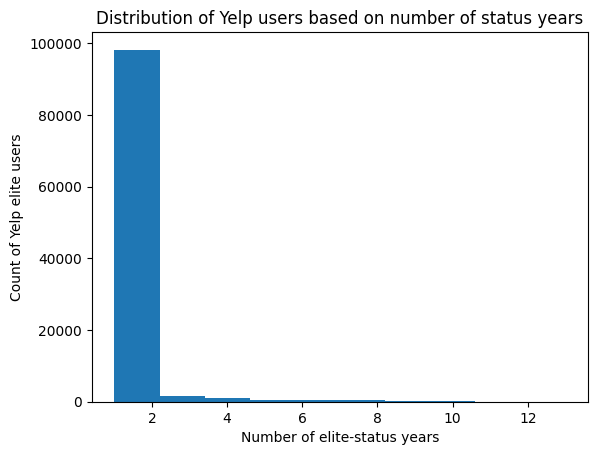

In [11]:
# Elite users duration
data_user = df_usr.copy()

data_user['elite'] = data_user['elite'].astype(str)
data_user['elite years'] = data_user['elite'].apply(lambda x:len(x.split(',')))

plt.hist(data_user['elite years']);

plt.title('Distribution of Yelp users based on number of status years');
plt.ylabel('Count of Yelp elite users');
plt.xlabel('Number of elite-status years');

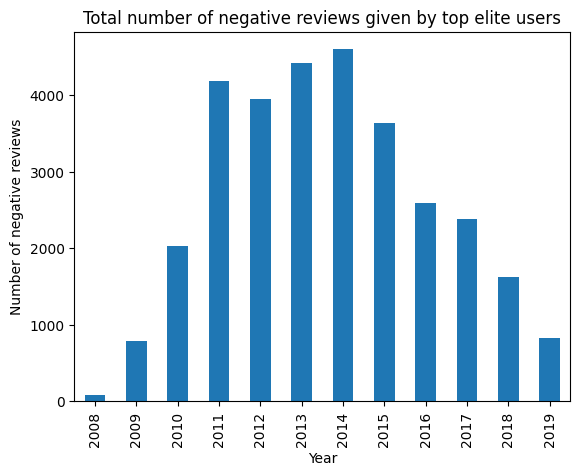

In [12]:
# Number of Negative reviews given by elite users

elite = data_user[data_user['elite years'] > 4].user_id.astype(str)
data_review_bad_elite = data_review[(data_review['user_id'].isin(elite)) & (data_review['stars'] < 4)]

plt.subplot()
ax = data_review_bad_elite.groupby('year')['stars'].sum().plot.bar()
plt.title('Total number of negative reviews given by top elite users');
plt.xlabel("Year");
plt.ylabel("Number of negative reviews");

In [13]:
# How long users have been active on yelp

data_user['yelping_since'] = data_user['yelping_since'].apply(pd.to_datetime)
data_user['yelp age'] = 2019 - data_user['yelping_since'].dt.year

user_agelevel = data_user['yelp age'].value_counts().reindex(range(len(data_user['yelp age'].unique())))
user_agelevel.index = ["Yelp age " + str(i) for i in range(len(data_user['yelp age'].unique()))]

user_agelevel

Yelp age 0      3039
Yelp age 1      5677
Yelp age 2      8183
Yelp age 3     12929
Yelp age 4     14951
Yelp age 5     14159
Yelp age 6     12081
Yelp age 7     10834
Yelp age 8      8795
Yelp age 9      5818
Yelp age 10     3565
Yelp age 11     1517
Yelp age 12      706
Yelp age 13      305
Yelp age 14       54
Yelp age 15        3
Name: yelp age, dtype: int64

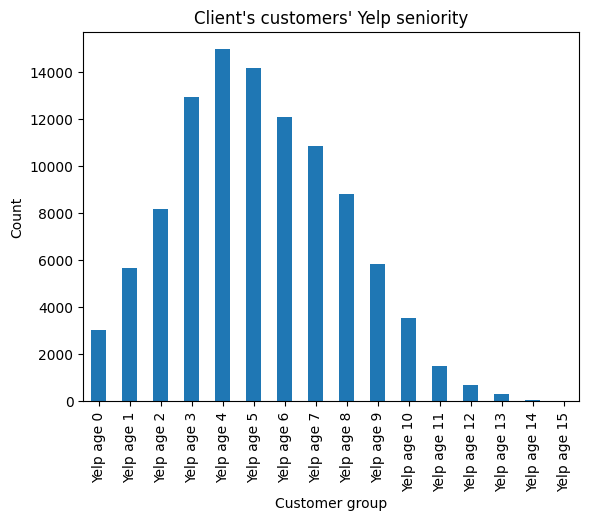

In [14]:
user_agelevel.plot.bar();
plt.title('Client\'s customers\' Yelp seniority');
plt.xlabel("Customer group");
plt.ylabel("Count");

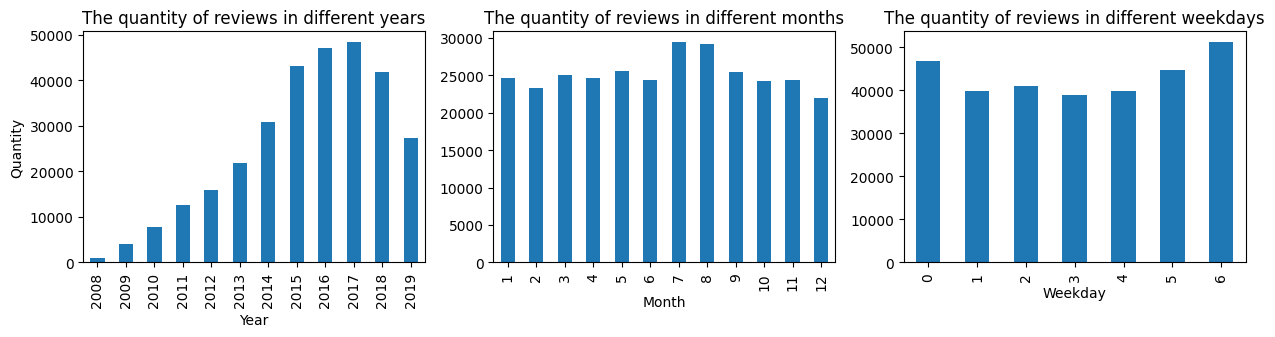

In [15]:
# Number of reviews by year, month, weekday
plt.subplot(131)
ax = data_review.groupby('year')['text'].count().plot.bar(figsize=(15,3))
plt.title('The quantity of reviews in different years');
plt.xlabel("Year");
plt.ylabel("Quantity");

plt.subplot(132)
ax = data_review.groupby('month')['text'].count().plot.bar()
plt.title('The quantity of reviews in different months');
plt.xlabel("Month");

plt.subplot(133)
ax = data_review.groupby('weekday')['text'].count().plot.bar()
plt.title('The quantity of reviews in different weekdays');
plt.xlabel("Weekday");

In [16]:
# Average review rating over the years
print(data_review.groupby('year')['stars'].mean())

year
2008    3.840385
2009    3.719170
2010    3.626033
2011    3.599257
2012    3.591948
2013    3.624920
2014    3.688539
2015    3.726859
2016    3.725672
2017    3.739556
2018    3.781035
2019    3.796739
Name: stars, dtype: float64


In [17]:
# Recieved Elite Status Quickly

elite = df_usr[['name', 'yelping_since', 'review_count', 'elite', 'fans', 'average_stars']]
elite = elite[elite['elite']!=""]
elite['elite_since'] =  pd.to_datetime(elite['elite'].apply(lambda x: x.split(',')[0]), format="%Y")
elite['elite_since'] = elite['elite_since']+pd.DateOffset(days=364)

elite['yelp_elite_diff'] = (elite['elite_since'] - elite['yelping_since'] )/ np.timedelta64(1, 'Y')
elite.sort_values(by='yelp_elite_diff')[:5]

## There have been users who have become elite within months of starting to use YELP
## This is probably due to the high volume of reviews given and their fan following
## They seem to be influencers in deciding which restaurants are good or not

,name,yelping_since,review_count,elite,fans,average_stars,elite_since,yelp_elite_diff
607,Rachel,2010-11-26 23:13:07,1069,"2010,2011,2012,2013,2014,2015,2016",448,3.97,2010-12-31,0.093178
18352,Jenny,2009-11-20 16:02:35,737,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018",53,3.66,2009-12-31,0.110424
18602,Vincci,2009-11-20 02:39:38,880,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018",93,3.89,2009-12-31,0.111951
25977,Bryan,2018-11-18 23:23:49,57,2018,1,3.98,2018-12-31,0.115061
31734,Seth,2010-11-12 06:04:38,321,"2010,2011,2012,2016",21,3.78,2010-12-31,0.133464


In [18]:
# Longest Elite status tenure
elite_ten = df_usr[['name', 'yelping_since', 'review_count', 'elite', 'fans', 'average_stars']]
et = elite_ten.loc[:40,]

def first_last_difference(row):
    if row:
        list_row = row.split(',')
        first, last = list_row[0], list_row[-1]
        return eval(last) - eval(first)
    else:
        return np.nan

elite_ten['elite_tenure'] = elite_ten['elite'].apply(lambda x: first_last_difference(x))
elite_ten.sort_values(by='elite_tenure', ascending=False)[:7]

,name,yelping_since,review_count,elite,fans,average_stars,elite_tenure
54676,Jessi,2006-08-23 19:56:06,381,"2006,2007,2008,2009,2012,2013,2014,2015,2016,2...",45,3.87,12.0
18319,Amy,2006-08-26 04:28:29,1839,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...",109,3.87,12.0
137,Megan,2005-06-03 04:08:16,845,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...",618,4.09,12.0
358,Leang,2006-06-18 04:18:27,2122,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...",91,3.87,12.0
337,Ed,2006-07-22 01:22:26,4913,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...",2034,3.66,12.0
18362,Mimi,2005-04-14 23:50:38,1246,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...",133,4.13,12.0
305,Mihir,2006-03-03 07:03:41,1387,"2006,2007,2008,2009,2010,2017,2018",67,3.08,12.0


In [19]:
# Most Reviews but not elite
df_usr[['name', 'yelping_since', 'review_count',
        'elite', 'fans', 'average_stars']][df_usr['elite']==''].sort_values(by='review_count', ascending=False)[:5]

,name,yelping_since,review_count,elite,fans,average_stars
1188,Kenneth,2011-06-10 03:52:07,6762,,275,3.32
986,Inigo,2006-03-14 22:23:23,2552,,63,3.55
44646,Matt,2009-11-08 21:35:17,2255,,167,4.64
965,Fancypants,2008-12-12 00:23:01,2162,,166,3.69
2993,Stefan,2013-05-01 15:07:23,1892,,27,3.75


# Prerocessing / Feature Engineering

## Yelp Age, Elite Years, No. Friends

In [20]:
# Number of years on yelp

def yelp_age(date):
    end_year = pd.to_datetime("2019-12-13 15:46:07",
                              format="%Y-%m-%d %H:%M:%S")
    year_diff = (end_year - date) / np.timedelta64(1, 'Y')
    return year_diff

# Number of years elite
def elite_years(text):
    if text=="":
      return 0
    else:
      n_elite = len(text.split(','))
      return n_elite

In [21]:
# Yelp Age
df_usr['yelp_age'] = df_usr['yelping_since'].apply(lambda x: yelp_age(x))

In [22]:
# Number of years elite
df_usr['elite_years'] = df_usr['elite'].apply(lambda x: elite_years(x))

In [23]:
# Number of friends
df_usr['no_friends'] = df_usr['friends'].apply(lambda x: len(x.split()))

In [24]:
# Drop unnecessary columns
du1 = df_usr.drop(['name', 'yelping_since', 'elite', 'friends'], axis=1)

In [25]:
du1.shape

(102616, 21)

## PCA

In [26]:
sc = StandardScaler()
usr_scaled = sc.fit_transform(du1.drop(['user_id'], axis=1))

In [27]:
pca = PCA()
pc_components = pca.fit_transform(usr_scaled)
pca_var = np.round(pca.explained_variance_ratio_*100, decimals=1)

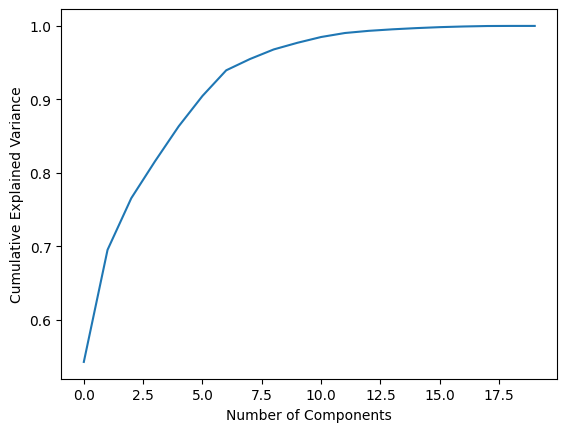

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [29]:
# We will use 5 pc components
pc_df = pd.DataFrame(data = pc_components,
                     columns = ['PC' + str(x) for x in range(1, len(pca_var)+1)])
pc_df = pc_df[['PC1','PC2','PC3','PC4','PC5']]

In [30]:
# Merge with the usr data
pc_df.insert(loc=0, column='user_id', value=df_usr['user_id'])
pc_df.head(3)

,user_id,PC1,PC2,PC3,PC4,PC5
0,I_6wY8_RsewziNnKhGZg4g,2.605179,-2.942905,4.751071,-0.195283,-1.652523
1,q-v8elVPvKz0KvK69QSj1Q,9.852222,-8.241025,6.218489,1.326913,0.603411
2,dIIKEfOgo0KqUfGQvGikPg,71.786864,-24.498644,6.382843,4.843934,8.509165


In [ ]:
# save data as csv to be used later for modelling
pc_df.to_csv('./data2/user_dataset.csv', index=None)